<a href="https://colab.research.google.com/github/jesusmiguel123/PC-5/blob/main/Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En el presente cuaderno se utilizará la arquitectura de los transformers introducida en el paper 'Atention is All you need', se enfocará en implementar múltiples métodos de decodificación (decoders) además de evaluar y comparar la calidad del texto que producen.

Se utilizará un modelador de lenguaje en español
https://huggingface.co/datificate/gpt2-small-spanish
 basado del conocido generador de texto GPT-2, en adición se utilizará una API de transformers realizada por Hugging Face. https://github.com/huggingface/transformers

#Inicio
Instalamos la librería de transformers


In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 895 kB 5.2 MB/s 
     |████████████████████████████████| 636 kB 11.8 MB/s 
     |████████████████████████████████| 3.3 MB 23.7 MB/s 


Realizamos los imports correspondientes para utilizar el tokenizer y el modelo de gpt2-small-spanish

In [2]:

import torch

from transformers import AutoTokenizer, AutoModelWithLMHead
  
tokenizer = AutoTokenizer.from_pretrained("datificate/gpt2-small-spanish")
model = AutoModelWithLMHead.from_pretrained("datificate/gpt2-small-spanish")
torch.manual_seed(0)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:920: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


#Decoders

## Búsqueda Greedy

In [3]:
#Especificamos el mensaje base, y el tipo de retorno del tokenizer como pt(pytorch)

message = "El ave volo sobre el monte hacia el horizonte"
input = tokenizer(message , return_tensors='pt')
print(input)

{'input_ids': tensor([[  491, 11512,  1017,    79,   623,   284,  8225,  1155,   284, 22336]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


En el paso anterior se pasa el tokenizer al mensaje, esto nos devuelve un dictionary, con un id que corresponde a una palabra, y una máscara de atención(en este caso esta llena de 1 debido a que todos los valores deben ser tomados)

Lo siguiente es pasar al model el mesange tokenizado para que genere nuevo texto, en el caso del enfoque greedy en cada paso se escoge la siguiente palabra con más probabilidad de ser escogida.

En la imagen cuando la última palabra es THE entonces tenemos 3 opciones:


1.  Dog: con 0.4%
2.  Nice: con 0.5%
3.  Car: con 0.1%

En este caso se escogerá la palabra Nice debido a que tiene mayor probabilidad, al siguiente paso sucede algo similar, entonces se escoge la palabra woman debido a que tiene mayor probabilidad que las otras.

Entonces la frase resultante es: The nice woman




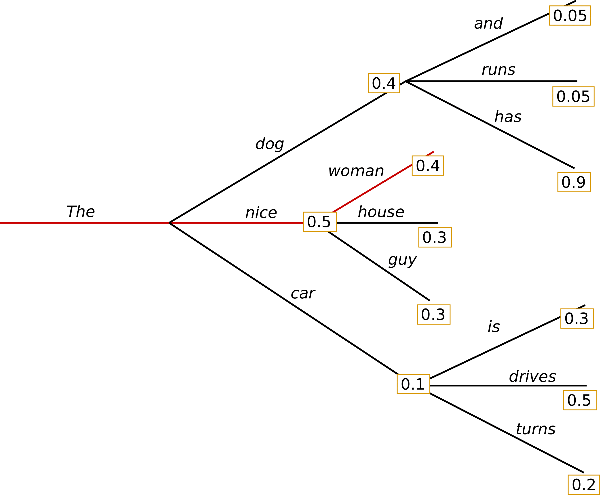

Generamos el texto y especificamos la longitud del tensor resultante

In [4]:
text = model.generate(**input, max_length=150)
print(text)
print(type(text))
print(text.shape)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[  491, 11512,  1017,    79,   623,   284,  8225,  1155,   284, 22336,
            14,   199,   199,   491,  5099,   258,   276, 30750,   293,   298,
          2336,   258,   276,  3296,    12,   301,   306, 17359,   278,   284,
          3608,    12,   287,   301,   306, 17359,   278,   284,  3608,    14,
           486, 30750,   306, 17359,   278,   284,  3608,    12,   287,   306,
         17359,   278,   284,  3608,    14,   486, 30750,   306, 17359,   278,
           284,  3608,    12,   287,   306, 17359,   278,   284,  3608,    14,
           486, 30750,   306, 17359,   278,   284,  3608,    12,   287,   306,
         17359,   278,   284,  3608,    14,   486, 30750,   306, 17359,   278,
           284,  3608,    12,   287,   306, 17359,   278,   284,  3608,    14,
           486, 30750,   306, 17359,   278,   284,  3608,    12,   287,   306,
         17359,   278,   284,  3608,    14,   486, 30750,   306, 17359,   278,
           284,  3608,    12,   287,   306, 17359,  

El método tokenizer.decode transforma un tensor de ids al vocabulario (texto entendible para las personas), como parámetros opcional especificamos obviar caracteres especiales como classifiers o separators.

In [5]:
print(tokenizer.decode(text[0], skip_special_tokens=True))

El ave volo sobre el monte hacia el horizonte.

El vuelo de la paloma es un movimiento de la cabeza, que se mueve en el aire, y que se mueve en el aire. La paloma se mueve en el aire, y se mueve en el aire. La paloma se mueve en el aire, y se mueve en el aire. La paloma se mueve en el aire, y se mueve en el aire. La paloma se mueve en el aire, y se mueve en el aire. La paloma se mueve en el aire, y se mueve en el aire. La paloma se mueve en el aire, y se mueve en el aire. La paloma se mueve en el aire, y se mueve en el aire. La paloma se mueve en


Conclusión:

Notamos que este método caemos fácilmente en repeticiones lo cual no nos resulta tan útil.

##Beam search


En este método se escogerá mútiples secuencias, siempre tratando de buscar las secuencias con mayor probabilidad y manteniendo el mismo número de secuencias.

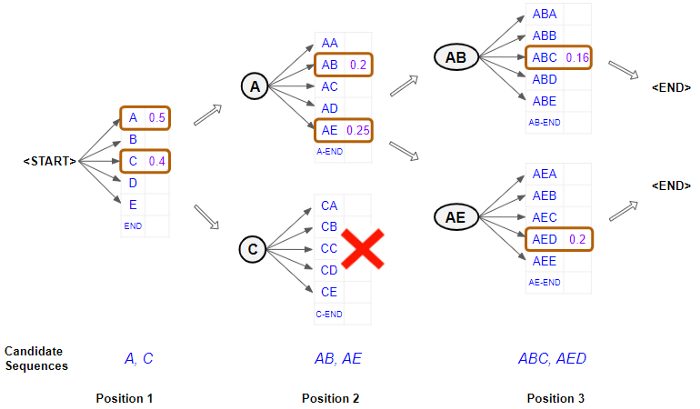

En este ejemplo empezamos con las 2 probabilidades más altas(A y C).

Luego en el siguiente paso tenemos 10 nuevas alternativas (5 de seguir A y 5 de seguir C), en este caso las que maximixan son las secuencias de A (AB, AE) asi que seguimos esas secuencias.

Finalmente se repite el mismo procedimiento dando como resultado dos secuencias ( ABC, AED).


In [6]:
#Especificamos algunos parámetros antes de realizar la búsqueda beam
n_beams = 5 #Número de secuencias que se van a seguir
ngram_no_repeat = 3  #La longitud de los n-gramas que no se pueden repetir


Generamos n_beams salidas utilizando la busqueda beam.

In [7]:
beam = model.generate(
    **input,
    max_length=150,
    num_beams= n_beams,
    early_stopping=True,
    no_repeat_ngram_size= ngram_no_repeat,
    num_return_sequences= n_beams,
)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [8]:
#imprimimos los resultados obtenidos
for i, output in enumerate(beam):
  print(f'{i}: {tokenizer.decode(output, skip_special_tokens=True)}')
  print("", end='\n\n')

0: El ave volo sobre el monte hacia el horizonte.

En la mitología griega, el ave volaba sobre el Monte Olimpo, en el monte Olimpo. En la mitología romana, el águila volaba en el cielo, y en la mitología egipcia, el halcón volaba alrededor del Monte Olimpo. 

En el folclore griego, el pájaro volaba a lo largo de la costa del mar Mediterráneo. En el folclore egipcio, el vuelo de un pájaro volador sobre el mar Mediterráneo era una forma de volar sobre la tierra. En los mitos griegos, el avión volador era un ave voladora que volaba hacia el cielo. En las religiones animistas, el volador volador es un animal volador que vuela sobre la Tierra.



1: El ave volo sobre el monte hacia el horizonte.

En la mitología griega, el ave volaba sobre el Monte Olimpo, en el monte Olimpo. En la mitología romana, el águila volaba en el cielo, y en la mitología egipcia, el halcón volaba alrededor del Monte Olimpo. 

En el folclore griego, el pájaro volaba a lo largo de la costa del mar Mediterráneo. En el

Conclusión:

Hemos mejorado un poco con respecto a greedy Search pero aún el texto no es tan espontáneo ni natural como el de los humanos, para ello se introducirá aleatoriedad.

## Sampling
Está ténica consiste en escoger de manera aleatoria basado en la probabilidad condicional, en el ejemplo que tenemos abajo podemos notar que ya no estamos escogiendo la siguiente palabra con mayor probabilidad de suceder, estamos escogiendo la palabra car que es la que menor probabilidad tiene, esto genera que nuestra elección ya no sea determinista.


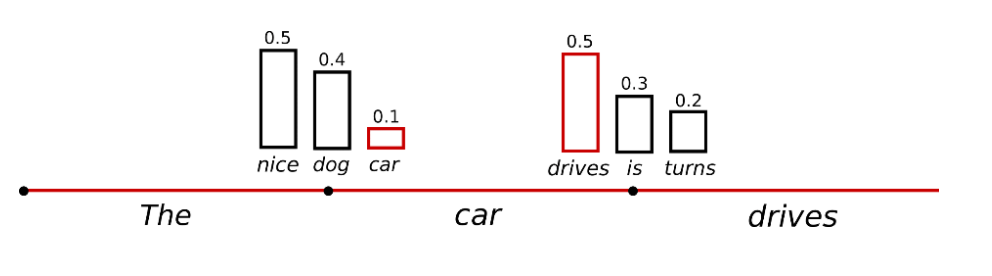

Para utilizar está carácteristica debemos especificar el parámetro do_sample = True, e iniciar una semilla.

Un problema con esto es que al ser aleatorio puede generar problemas de coherencia debido a que estamos escogiendo de manera aleatoria sin ningún tipo de control, para ello utilizaremos el concepto de temperature.

temperature lo que hace es antes de realizar la activación softmax divide los logits entre la temperatura, esto hace que se produzcan valores de mayor tamaño haciendo que los valores con alta probabilidad suban y los valores con baja probabilidad bajen, de este manera se tiene más chance que se escogan los valores más probables 


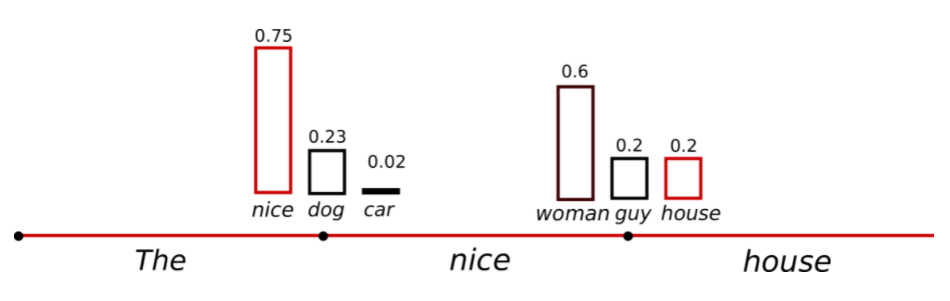

In [9]:

sample = model.generate(
    **input,
    max_length=150,
    do_sample = True,
    top_k = 0, #este parámetro se explicará más adelante
    temperature=0.7
)

print(tokenizer.decode(sample[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


El ave volo sobre el monte hacia el horizonte, y va al lado de la fuente, en el camino de la fuente, se acerca a la fuente, y se acerca a la fuente, y gira con los brazos sobre la fuente. Cuando el ave gira en el sentido de la dirección, su vuelo es lenta, y la velocidad es lenta, y la velocidad es lenta, y la velocidad es lenta, y su movimiento es rápida, y la velocidad es lenta, y la velocidad es lenta, y la velocidad es lenta, y la velocidad es lenta. La velocidad del ave es muy lenta en el sentido de la dirección, y la velocidad de la ave es muy lenta en el sentido de la dirección. La velocidad del ave es muy lenta en


  Conclusión:

  El texto es un poco más impredecible pero existen incoherencias en el significado, para ello utilizaremos otro método para filtrar que palabras se deben escoger

## Top-k Sampling

Este método lo que hace es filtrar las k palabras más probables y redistribuir las probabilidades entre esas k palabras, imaginemos que tenemos una distribución de la siguiente manera:

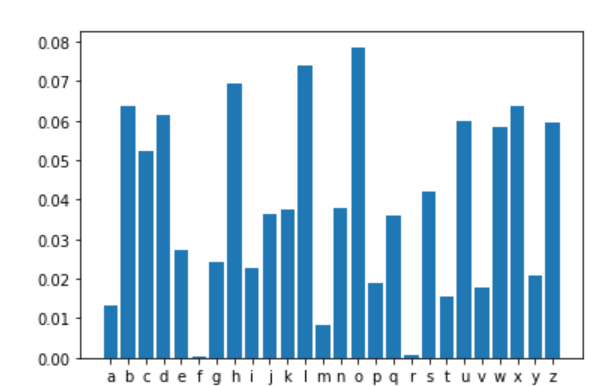

Entonces si especificamos k=5, se escogerán las 5 letras con más probabilidad, se redistribuirán las probabilidades y entre ellas se realizará el método sampling


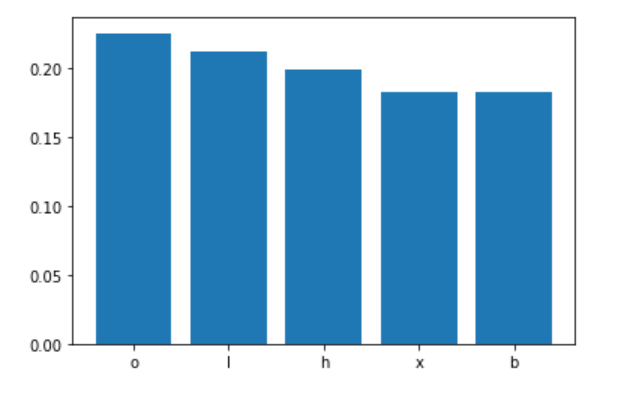

Para utilizar esto simplemente debemos especificar el tamaño de top_k

In [10]:
topk_sample = model.generate(
    **input,
    max_length=150,
    do_sample = True,
    top_k = 20, 
    temperature=0.7
)

print(tokenizer.decode(topk_sample[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


El ave volo sobre el monte hacia el horizonte, el pájaro vuela hacia el suelo y los pájaros vuelan hacia el cielo. Si bien los pájaros vuelan en los cielos, la especie humana no vuela sobre ellos.

Cuando los pájaros vuelan en los cielos, los pájaros vuelan a través del cielo, y los pájaros vuelan en el cielo. Si los pájaros vuelan en los cielos, los pájaros vuelan en el cielo y los pájaros vuelan en el cielo. Si los pájaros vuelan en el cielo, los pájaros vuelan en el cielo y los pájaros vuelan en el cielo. Si los pájaros vuelan en el cielo, los pájaros vuelan en el cielo y los pájaros vuelan en el cielo.

Un pájaro vuela en el cielo si se acerca a él en un círculo


Conclusión:

El texto es mucho más humano pero existe un problema que cuando las probabilidades de las palabras son muy disparejas o muy similares siempre se escoge el mismo número de palabras, esto hace parecer que escoger un número de palabras definido no parece ser la mejor técnica pero aún asi produce un buen resultado.

##Top-p Sampling

En este caso se va a definir una probabilidad p, entonces se escogerá el subconjunto de menor tamaño de palabras de tal manera que su probabilidad acumulada sea mayor a p.

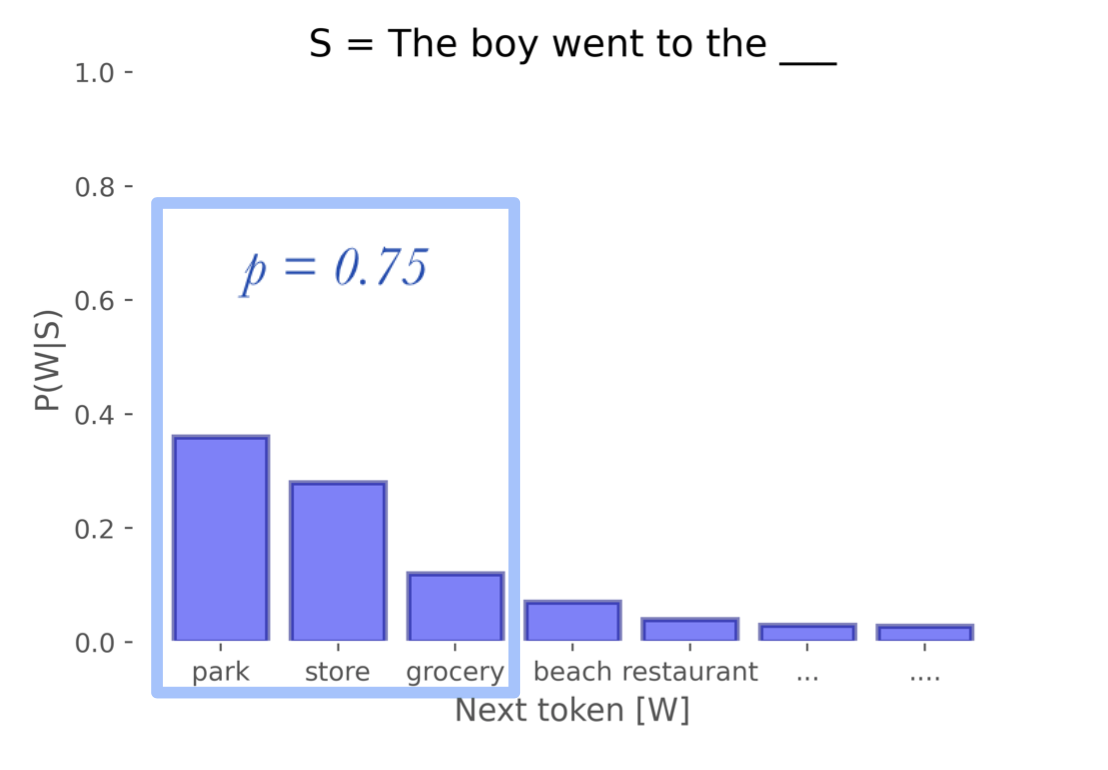

En este ejemplo como queremos minizimar el número de palabras y maximizar la probabilidad acumulada iremos escogiendo las palabras con mayor probabilidad hasta llegar a superar la probabilidad p.

Para implementar debemos poner el parámetro top_k=0 y utilizar el definir p que es el parámetro top_p.

In [11]:
top_p_sample = model.generate(
    **input,
    max_length=150,
    do_sample = True,
    top_k = 0,
    top_p = 0.91,
    temperature=0.7,
)

print(tokenizer.decode(top_p_sample[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


El ave volo sobre el monte hacia el horizonte.

En el mes de julio, el macho pone una pluma de cola negra con un pico negro en su pico. El macho pone una pluma de cola blanca con un pico negro en su pico. La hembra pone una pluma de cola blanca con un pico negro en su pico.

El macho pone una pluma de cola blanca con un pico negro en su pico.

El macho pone una pluma de cola blanca con un pico negro en su pico.

El macho pone una pluma de cola blanca con un pico negro en su pico.

La hembra pone una pluma de cola blanca con un pico negro en su pico.

La hembra pone una pluma de cola blanca con


También es común en la práctica utilizar top-k y top-p al mismo tiempo, vamos a realizar eso además de generar múltiples secuencias.

In [12]:
top_pk_sample = model.generate(
    **input,
    max_length=150,
    do_sample = True,
    top_k = 20,
    top_p = 0.91,
    temperature=0.7,
    num_return_sequences=3
)

for i, output in enumerate(top_pk_sample):
  print(f'{i}: {tokenizer.decode(output, skip_special_tokens=True)}')
  print("", end='\n\n')



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: El ave volo sobre el monte hacia el horizonte. El macho pone sus huevos en una especie de árbol, y en seguida el nido se encuentra abierto, donde los polluelos nacen en el suelo, y los polluelos son alimentados por otros polluelos. En los nidos los polluelos son alimentados por los padres, que los ayudan a volar.

La especie "B. volo" se alimenta de insectos, reptiles, y otros invertebrados. En la naturaleza el nido está cubierto por una capa de vegetación, pero no hay nada que lo confiese en él. El nido es de madera o paja, y los polluelos se alimentan de las hierbas.

Se alimenta principalmente de insectos, reptiles y otros invertebrados. Los huevos son de color marrón, y son incub


1: El ave volo sobre el monte hacia el horizonte, y a la altura de la cumbre. La parte superior de la montaña tiene un pequeño cráter, con una superficie de unos 2,5 km². El cráter es de 2,5 km² y tiene una altura de 1,5 km. La parte superior de la montaña es una pequeña meseta de unos 3 km de diámetr

Conclusión:

Utilizando lo aprendido podemos generar texto con un nivel de coherencia aceptable, además notamos que a diferencia de las secuencias generadas en beam search los resultados son diferentes y más impredecibles.
